In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import gzip

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.model_selection import KFold

plt.rcParams['axes.unicode_minus'] = False # 顯示負號

# set device to gpu
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'cuda'

In [11]:
# Load data
tfidf_train_data = pd.read_csv('../Data/TrainingData/tfidf_train.csv')
tfidf_test_data = pd.read_csv('../Data/ValidateData/tfidf_val.csv')

word2vec_train_data = pd.read_csv('../Data/TrainingData/word2vec_train.csv')
word2vec_test_data = pd.read_csv('../Data/ValidateData/word2vec_val.csv')

word2vec_selftrain_train_data = pd.read_csv('../Data/TrainingData/word2vec_selftrain_train.csv')
word2vec_selftrain_test_data = pd.read_csv('../Data/ValidateData/word2vec_selftrain_val.csv')

bert_train_data = pd.read_csv('../Data/TrainingData/bert_train.csv')
bert_test_data = pd.read_csv('../Data/ValidateData/bert_val.csv')

bert_selftrain_train_data = pd.read_csv('../Data/TrainingData/bert_selftrain_train.csv')
bert_selftrain_test_data = pd.read_csv('../Data/ValidateData/bert_selftrain_val.csv')

In [12]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

In [13]:
def train_gru_model_with_f2_score(train_df, test_df, model_path, scaler_path, input_size, hidden_size=128, num_layers=2, num_epochs=100, apply_pca=False, n_components=200):
    train_data = train_df.copy()
    test_data = test_df.copy()
    
    y_train = train_data.pop('source')  # 假設標籤列名為 'source'
    y_test = test_data.pop('source')  # 假設標籤列名為 'source'

    # 標準化數據
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_data.values)
    X_test_scaled = scaler.transform(test_data.values)

    # 是否應用 PCA
    if apply_pca:
        pca = PCA(n_components=n_components)
        X_train_scaled = pca.fit_transform(X_train_scaled)
        X_test_scaled = pca.transform(X_test_scaled)

    # 保存標準化器和PCA
    with gzip.open(scaler_path, 'wb') as f:
        joblib.dump(scaler, f)
    if apply_pca:
        with gzip.open(scaler_path.replace("scaler", "pca_gru"), 'wb') as f:
            joblib.dump(pca, f)

    # 10折交叉驗證
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    fold = 0
    confusion_matrices = []
    f2_scores = []
    best_model = None
    best_f2_score = float('-inf')

    for train_index, test_index in kf.split(X_train_scaled):
        fold += 1
        X_train, X_val = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # 將數據轉換為 PyTorch 張量並移動到 GPU
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)
        y_train_tensor = torch.tensor(y_train_fold.values, dtype=torch.float32).view(-1, 1).to(device)
        y_val_tensor = torch.tensor(y_val_fold.values, dtype=torch.float32).view(-1, 1).to(device)

        # 建立 GRU 模型
        model = GRUModel(input_size, hidden_size, num_layers, 1).to(device)

        # 定義損失函數和優化器
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # 訓練模型
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 10 == 0:
                print(f'Fold [{fold}], Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

        # 測試模型並計算F2 score
        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train_tensor)
            y_pred_val = model(X_val_tensor)

            y_pred_train = y_pred_train.cpu().numpy()
            y_pred_val = y_pred_val.cpu().numpy()

            y_pred_train = (y_pred_train > 0.5).astype(int)
            y_pred_val = (y_pred_val > 0.5).astype(int)

            y_train_numpy = y_train_tensor.cpu().numpy()
            y_val_numpy = y_val_tensor.cpu().numpy()

            cm_train = confusion_matrix(y_train_numpy, y_pred_train)
            cm_test = confusion_matrix(y_val_numpy, y_pred_val)
            confusion_matrices.append((cm_train, cm_test))

            f2 = fbeta_score(y_val_numpy, y_pred_val, beta=2)
            f2_scores.append(f2)

            # 保存最佳模型
            if f2 > best_f2_score:
                best_f2_score = f2
                best_model = model

    # 計算平均F2-score
    avg_f2_score = sum(f2_scores) / len(f2_scores)
    print(f'Average F2 Score: {avg_f2_score:.4f}')

    # 計算混淆矩陣加總再標準化
    sum_cm_train = sum([cm[0] for cm in confusion_matrices])
    sum_cm_val = sum([cm[1] for cm in confusion_matrices])

    norm_cm_train = sum_cm_train.astype('float') / sum_cm_train.sum(axis=1)[:, np.newaxis]
    norm_cm_val = sum_cm_val.astype('float') / sum_cm_val.sum(axis=1)[:, np.newaxis]

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Normalized Confusion Matrices')

    sns.heatmap(norm_cm_train, annot=True, fmt='.2f', ax=axs[0], cmap='Blues')
    axs[0].set_title('Normalized Train Confusion Matrix')
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('Actual')

    sns.heatmap(norm_cm_val, annot=True, fmt='.2f', ax=axs[1], cmap='Blues')
    axs[1].set_title('Normalized Validation Confusion Matrix')
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

    # 保存最佳模型
    torch.save(best_model.state_dict(), model_path)

    # 評估validation set
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

    best_model.eval()
    with torch.no_grad():
        y_test_pred = best_model(X_test_tensor)
        y_test_pred = y_test_pred.cpu().numpy()
        y_test_pred = (y_test_pred > 0.5).astype(int)
        y_test_numpy = y_test_tensor.cpu().numpy()

        test_cm = confusion_matrix(y_test_numpy, y_test_pred)
        test_f2_score = fbeta_score(y_test_numpy, y_test_pred, beta=2)

    print(f'Test F2 Score: {test_f2_score:.4f}')

    norm_test_cm = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(7, 5))
    sns.heatmap(norm_test_cm, annot=True, fmt='.2f', cmap='Blues')
    plt.title('Normalized Testing Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Fold [1], Epoch [10/100], Loss: 0.3954
Fold [1], Epoch [20/100], Loss: 0.1181
Fold [1], Epoch [30/100], Loss: 0.0364
Fold [1], Epoch [40/100], Loss: 0.0151
Fold [1], Epoch [50/100], Loss: 0.0088
Fold [1], Epoch [60/100], Loss: 0.0059
Fold [1], Epoch [70/100], Loss: 0.0044
Fold [1], Epoch [80/100], Loss: 0.0035
Fold [1], Epoch [90/100], Loss: 0.0029
Fold [1], Epoch [100/100], Loss: 0.0024
Fold [2], Epoch [10/100], Loss: 0.3854
Fold [2], Epoch [20/100], Loss: 0.1085
Fold [2], Epoch [30/100], Loss: 0.0323
Fold [2], Epoch [40/100], Loss: 0.0134
Fold [2], Epoch [50/100], Loss: 0.0080
Fold [2], Epoch [60/100], Loss: 0.0055
Fold [2], Epoch [70/100], Loss: 0.0042
Fold [2], Epoch [80/100], Loss: 0.0034
Fold [2], Epoch [90/100], Loss: 0.0028
Fold [2], Epoch [100/100], Loss: 0.0024
Fold [3], Epoch [10/100], Loss: 0.3980
Fold [3], Epoch [20/100], Loss: 0.1200
Fold [3], Epoch [30/100], Loss: 0.0367
Fold [3], Epoch [40/100], Loss: 0.0151
Fold [3], Epoch [50/100], Loss: 0.0088
Fold [3], Epoch [60/100

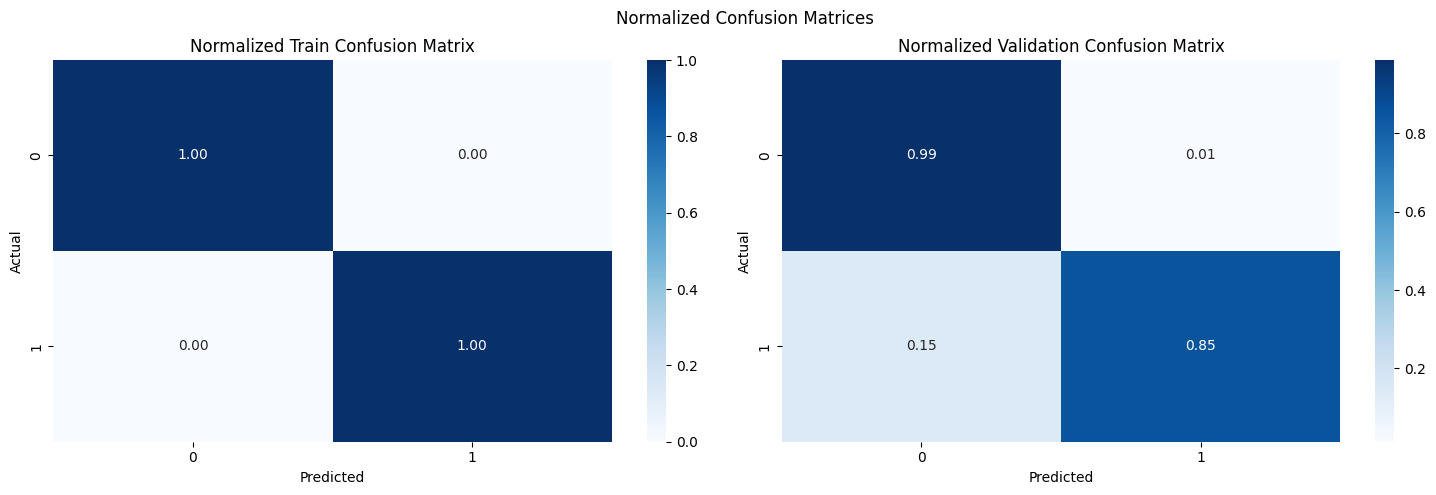

Test F2 Score: 0.9922


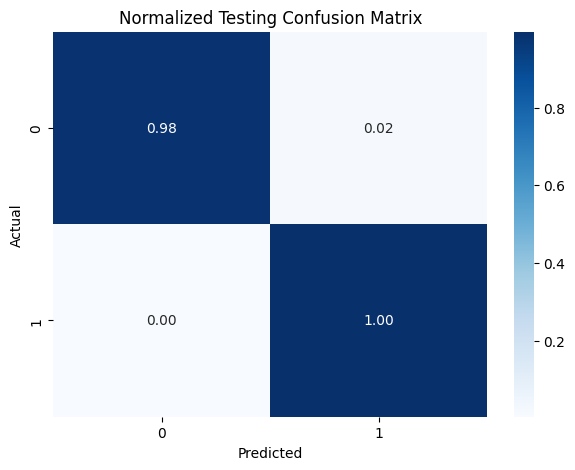

In [14]:
pca_n_components = 800
train_gru_model_with_f2_score(tfidf_train_data, tfidf_test_data, '../Data/Model/tfidf_gru_10fold_model.pth.gz', '../Data/Model/tfidf_10fold_scaler.pkl.gz', input_size=pca_n_components, apply_pca=True, n_components=pca_n_components)

Fold [1], Epoch [10/100], Loss: 0.4802
Fold [1], Epoch [20/100], Loss: 0.1724
Fold [1], Epoch [30/100], Loss: 0.0502
Fold [1], Epoch [40/100], Loss: 0.0194
Fold [1], Epoch [50/100], Loss: 0.0100
Fold [1], Epoch [60/100], Loss: 0.0060
Fold [1], Epoch [70/100], Loss: 0.0039
Fold [1], Epoch [80/100], Loss: 0.0028
Fold [1], Epoch [90/100], Loss: 0.0021
Fold [1], Epoch [100/100], Loss: 0.0017
Fold [2], Epoch [10/100], Loss: 0.4842
Fold [2], Epoch [20/100], Loss: 0.1749
Fold [2], Epoch [30/100], Loss: 0.0512
Fold [2], Epoch [40/100], Loss: 0.0200
Fold [2], Epoch [50/100], Loss: 0.0102
Fold [2], Epoch [60/100], Loss: 0.0060
Fold [2], Epoch [70/100], Loss: 0.0040
Fold [2], Epoch [80/100], Loss: 0.0029
Fold [2], Epoch [90/100], Loss: 0.0022
Fold [2], Epoch [100/100], Loss: 0.0018
Fold [3], Epoch [10/100], Loss: 0.4577
Fold [3], Epoch [20/100], Loss: 0.1624
Fold [3], Epoch [30/100], Loss: 0.0486
Fold [3], Epoch [40/100], Loss: 0.0196
Fold [3], Epoch [50/100], Loss: 0.0102
Fold [3], Epoch [60/100

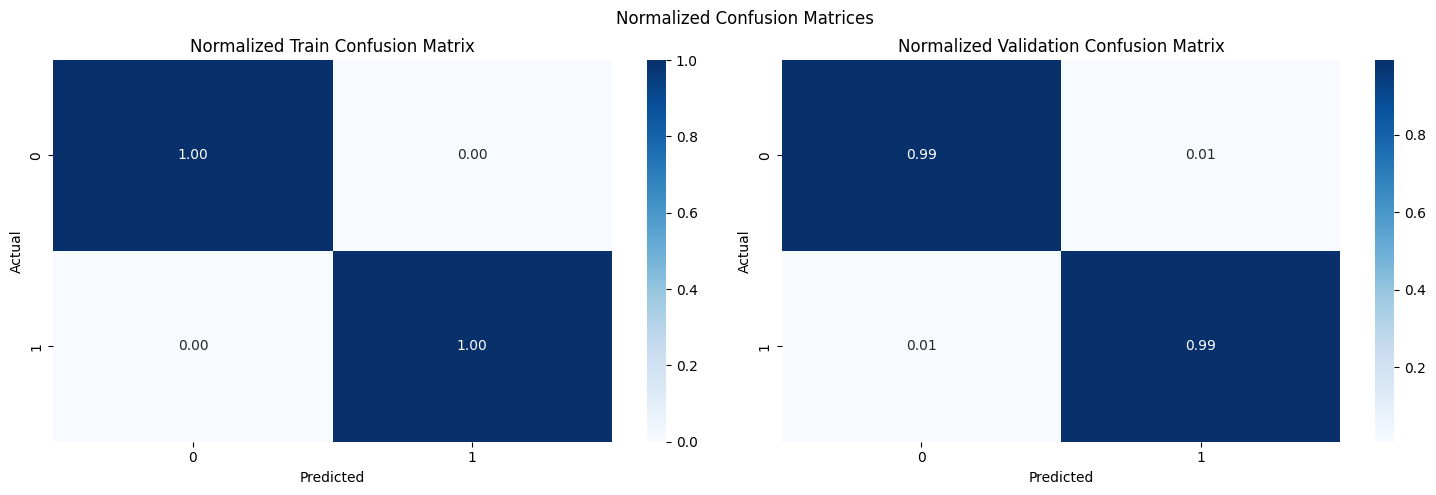

Test F2 Score: 0.9951


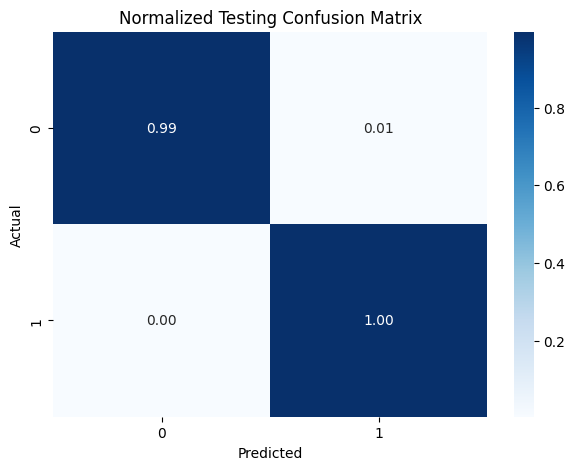

In [15]:
word2vec_selftrain_input_size = word2vec_selftrain_train_data.shape[1] - 1
train_gru_model_with_f2_score(word2vec_selftrain_train_data, word2vec_selftrain_test_data, '../Data/Model/word2vec_selftrain_gru_10fold_model.pth.gz', '../Data/Model/word2vec_selftrain_10fold_scaler.pkl.gz', word2vec_selftrain_input_size)

Fold [1], Epoch [10/100], Loss: 0.4563
Fold [1], Epoch [20/100], Loss: 0.1883
Fold [1], Epoch [30/100], Loss: 0.0880
Fold [1], Epoch [40/100], Loss: 0.0479
Fold [1], Epoch [50/100], Loss: 0.0271
Fold [1], Epoch [60/100], Loss: 0.0156
Fold [1], Epoch [70/100], Loss: 0.0098


Fold [1], Epoch [80/100], Loss: 0.0065
Fold [1], Epoch [90/100], Loss: 0.0046
Fold [1], Epoch [100/100], Loss: 0.0034
Fold [2], Epoch [10/100], Loss: 0.4378
Fold [2], Epoch [20/100], Loss: 0.1768
Fold [2], Epoch [30/100], Loss: 0.0842
Fold [2], Epoch [40/100], Loss: 0.0460
Fold [2], Epoch [50/100], Loss: 0.0264
Fold [2], Epoch [60/100], Loss: 0.0153
Fold [2], Epoch [70/100], Loss: 0.0096
Fold [2], Epoch [80/100], Loss: 0.0065
Fold [2], Epoch [90/100], Loss: 0.0046
Fold [2], Epoch [100/100], Loss: 0.0035
Fold [3], Epoch [10/100], Loss: 0.4678
Fold [3], Epoch [20/100], Loss: 0.1949
Fold [3], Epoch [30/100], Loss: 0.0890
Fold [3], Epoch [40/100], Loss: 0.0467
Fold [3], Epoch [50/100], Loss: 0.0265
Fold [3], Epoch [60/100], Loss: 0.0151
Fold [3], Epoch [70/100], Loss: 0.0092
Fold [3], Epoch [80/100], Loss: 0.0060
Fold [3], Epoch [90/100], Loss: 0.0042
Fold [3], Epoch [100/100], Loss: 0.0031
Fold [4], Epoch [10/100], Loss: 0.4708
Fold [4], Epoch [20/100], Loss: 0.1926
Fold [4], Epoch [30/10

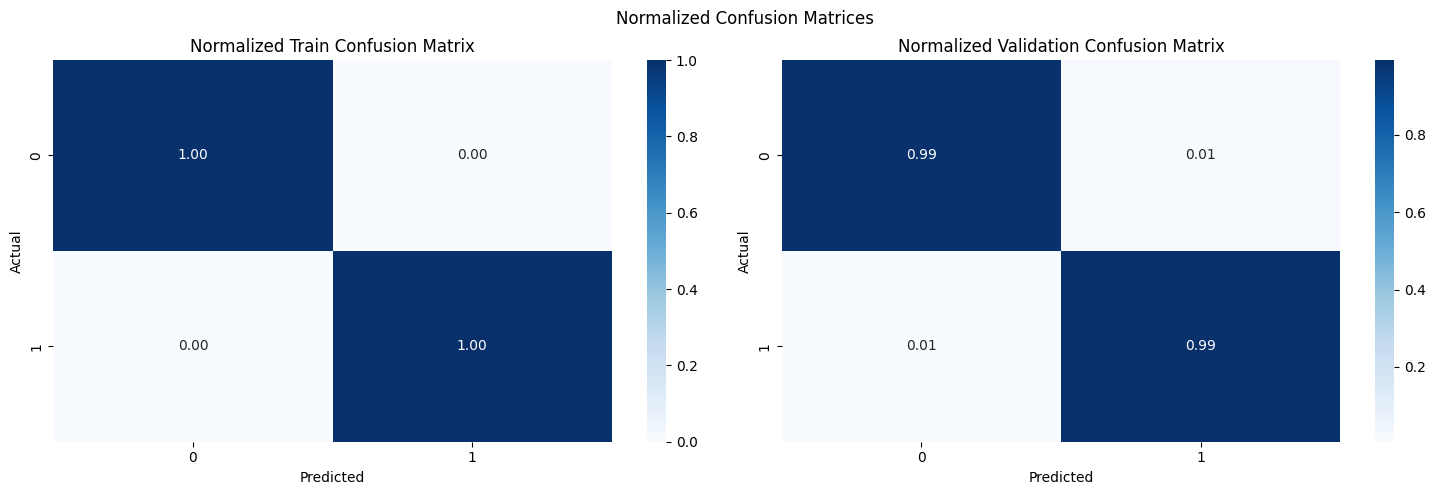

Test F2 Score: 0.9844


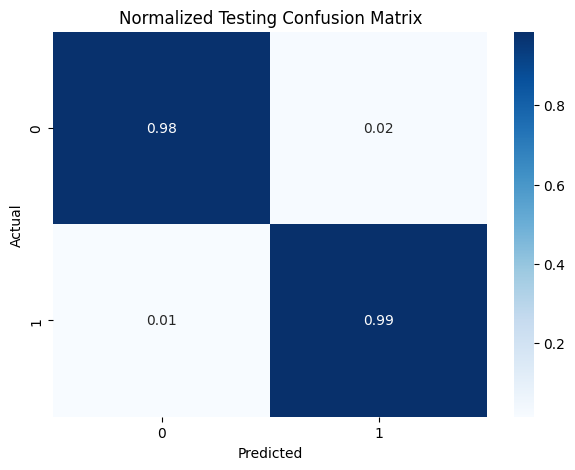

In [16]:
word2vec_input_size = word2vec_train_data.shape[1] - 1
train_gru_model_with_f2_score(word2vec_train_data, word2vec_test_data, '../Data/Model/word2vec_gru_10fold_model.pth.gz', '../Data/Model/word2vec_10fold_scaler.pkl.gz', word2vec_input_size)

Fold [1], Epoch [10/100], Loss: 0.2522
Fold [1], Epoch [20/100], Loss: 0.0427
Fold [1], Epoch [30/100], Loss: 0.0092
Fold [1], Epoch [40/100], Loss: 0.0033
Fold [1], Epoch [50/100], Loss: 0.0018
Fold [1], Epoch [60/100], Loss: 0.0012
Fold [1], Epoch [70/100], Loss: 0.0010
Fold [1], Epoch [80/100], Loss: 0.0008
Fold [1], Epoch [90/100], Loss: 0.0007
Fold [1], Epoch [100/100], Loss: 0.0006
Fold [2], Epoch [10/100], Loss: 0.2413
Fold [2], Epoch [20/100], Loss: 0.0402
Fold [2], Epoch [30/100], Loss: 0.0088
Fold [2], Epoch [40/100], Loss: 0.0032
Fold [2], Epoch [50/100], Loss: 0.0018
Fold [2], Epoch [60/100], Loss: 0.0013
Fold [2], Epoch [70/100], Loss: 0.0010
Fold [2], Epoch [80/100], Loss: 0.0008
Fold [2], Epoch [90/100], Loss: 0.0007
Fold [2], Epoch [100/100], Loss: 0.0006
Fold [3], Epoch [10/100], Loss: 0.2403
Fold [3], Epoch [20/100], Loss: 0.0392
Fold [3], Epoch [30/100], Loss: 0.0083
Fold [3], Epoch [40/100], Loss: 0.0030
Fold [3], Epoch [50/100], Loss: 0.0017
Fold [3], Epoch [60/100

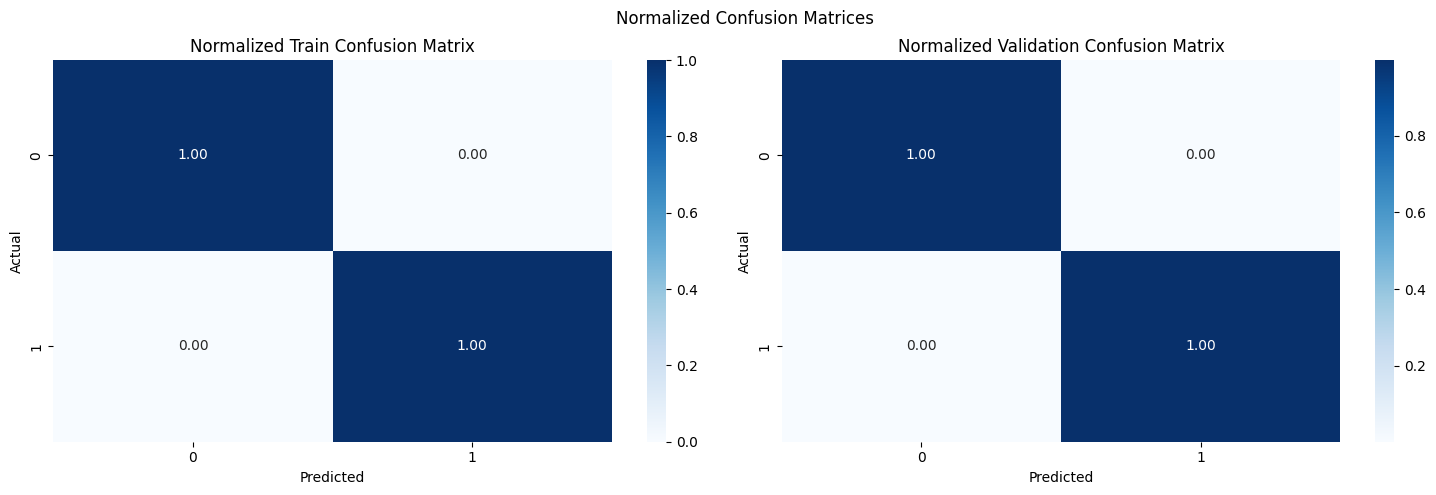

Test F2 Score: 1.0000


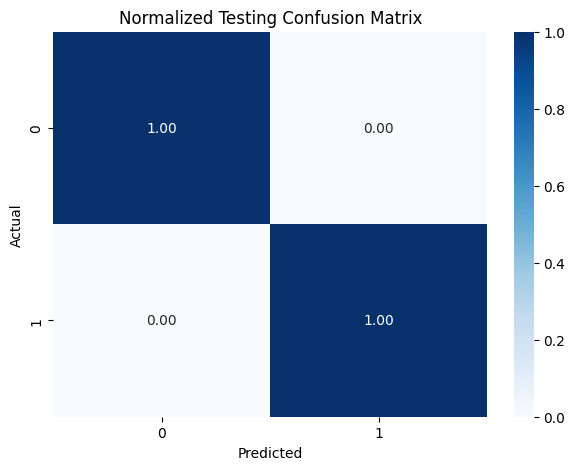

In [28]:
bert_selftrain_input_size = bert_selftrain_train_data.shape[1] - 1
train_gru_model_with_f2_score(bert_selftrain_train_data, bert_selftrain_test_data, '../Data/Model/bert_selftrain_gru_10fold_model.pth.gz', '../Data/Model/bert_selftrain_10fold_scaler.pkl.gz', bert_selftrain_input_size)

Fold [1], Epoch [10/100], Loss: 0.2503
Fold [1], Epoch [20/100], Loss: 0.0402
Fold [1], Epoch [30/100], Loss: 0.0085
Fold [1], Epoch [40/100], Loss: 0.0032
Fold [1], Epoch [50/100], Loss: 0.0018
Fold [1], Epoch [60/100], Loss: 0.0013
Fold [1], Epoch [70/100], Loss: 0.0010
Fold [1], Epoch [80/100], Loss: 0.0009
Fold [1], Epoch [90/100], Loss: 0.0008
Fold [1], Epoch [100/100], Loss: 0.0007
Fold [2], Epoch [10/100], Loss: 0.2485
Fold [2], Epoch [20/100], Loss: 0.0427
Fold [2], Epoch [30/100], Loss: 0.0093
Fold [2], Epoch [40/100], Loss: 0.0034
Fold [2], Epoch [50/100], Loss: 0.0018
Fold [2], Epoch [60/100], Loss: 0.0013
Fold [2], Epoch [70/100], Loss: 0.0010
Fold [2], Epoch [80/100], Loss: 0.0008
Fold [2], Epoch [90/100], Loss: 0.0007
Fold [2], Epoch [100/100], Loss: 0.0006
Fold [3], Epoch [10/100], Loss: 0.2415
Fold [3], Epoch [20/100], Loss: 0.0417
Fold [3], Epoch [30/100], Loss: 0.0095
Fold [3], Epoch [40/100], Loss: 0.0035
Fold [3], Epoch [50/100], Loss: 0.0019
Fold [3], Epoch [60/100

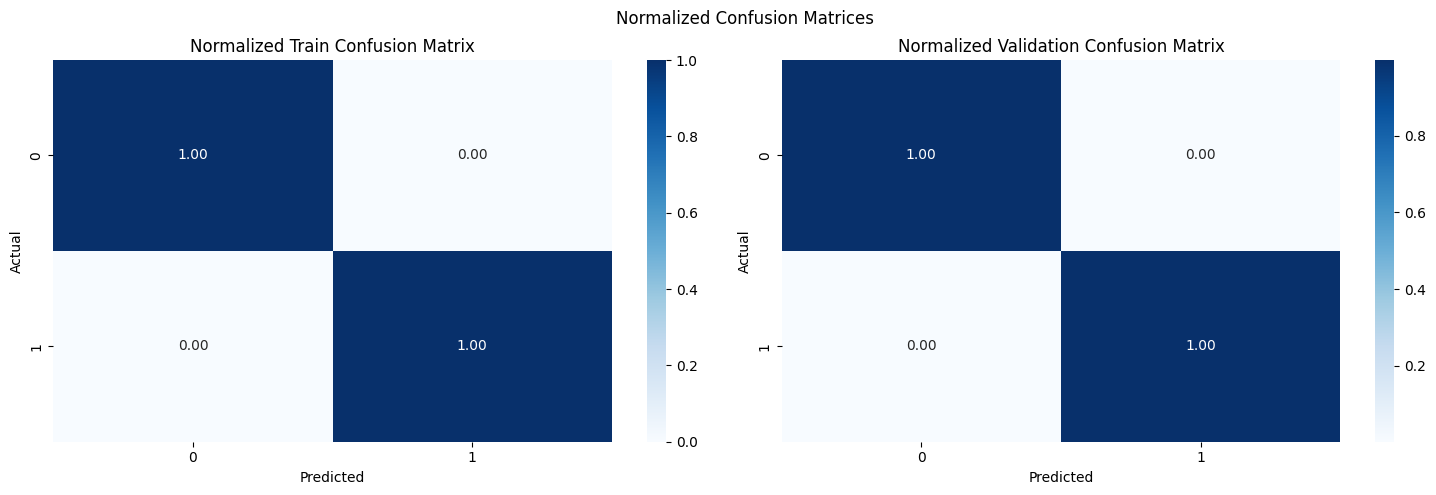

Test F2 Score: 1.0000


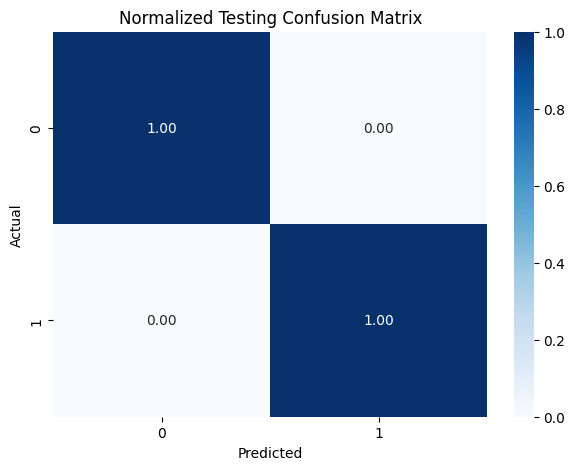

In [19]:
bert_input_size = bert_train_data.shape[1] - 1
train_gru_model_with_f2_score(bert_train_data, bert_test_data, '../Data/Model/bert_gru_10fold_model.pth.gz', '../Data/Model/bert_10fold_scaler.pkl.gz', bert_input_size)